In [1]:
import pytimber
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

year="2017"

doProduceNewFiles = False

In [2]:
# The online operational data of the Large Hadron Collider (LHC) are stored in a Logging Database
# This databased can be accessed through the timber interface, or through its python version pytimber
# https://github.com/rdemaria/pytimber
# This notebook shows an example of a systematic retreival of beam intensity quantities in each 2017 run of the LHC
# The goal is to calculate the total number of protons per beam that are lost in collimators and/or absorbers of the accelerator while the accelerator is operating at top energy (6.5 TeV)

# Note: each LHC run consists of a sequence of beam modes. 
# Below: list of beam mode codes as logged in the "HX:BMODE" timber variable
#setup 2
#injection probe beam 3
#injection setup beam 4
#injection physics beam 5
#prepare ramp 6
#ramp 7
#flat top 8
#squeeze 9
#adjust 10
#stable beams 11
#unstable beams 12
#beam dump 13
#ramp down 14
#recovery 15
#inject and dump 16
#circulate and dump 17
#abort 18
#cycling 19
#beam dump warning 20
#no beam 21
#prepare injection 22

In [3]:
# initialize LDB with pytimber
ldb = pytimber.LoggingDB()

In [4]:
var_mode = "HX:BMODE"

# '2018-08-06 07:00:00','2018-08-07 06:01:00' : good proton run

def scanPeriod(start, end):

    # Retrieve beam mode information from pytimber for the desired period
    # pytimber data structure: dictionary with timestamp and value vectors
    d_beammodes=ldb.get([var_mode], start,end)
    t_beammodes,v_beammodes=d_beammodes[var_mode]

    # Retrieve list of fills where the 'stable beam' operation is reached
    fills = ldb.getLHCFillsByTime(start, end, beam_modes='STABLE') 
    
    #print (f for f in fills)
    print (fills[0])
    fillnumbers = []
    fillsize=dict()
    starttimes = dict()
    endtimes = dict()
    for i in range(0,len(fills)) :
        fillnum = fills[i]['fillNumber']
        fillnumbers.append(fillnum)
        beammodes = fills[i]['beamModes']
        #print (len(beammodes))
        jflattop = 0
        jstable = 0
        foundFlatTop = False
        foundStable = False
        fillsize[fillnum]=0
        starttimes[fillnum]=[]
        endtimes[fillnum]=[]
        for j in range (0,len(beammodes)) :
            if jflattop==0 and beammodes[j]['mode']=='FLATTOP' and foundFlatTop==False and foundStable==False:
                startflattop = beammodes[j]['startTime']
                #starttimes[fillnum].append(beammodes[j]['startTime'])
                jflattop = j
                foundFlatTop = True
            if j>jflattop and beammodes[j]['mode']=='FLATTOP' and foundFlatTop==True and foundStable==False : #two flat tops before stable beams
                startflattop = beammodes[j]['startTime']
                jflattop = j
            if j>jflattop and beammodes[j]['mode']=='STABLE' and foundFlatTop==True and foundStable==False : #standard situation: stable beams after ramp
                starttimes[fillnum].append(startflattop)
                endtimes[fillnum].append(beammodes[j]['endTime'])
                fillsize[fillnum]+=1
                jstable = j
                foundStable = True
                foundFlatTop = False
            if j>jstable and beammodes[j]['mode']=='STABLE' and foundStable==True : #more than 1 stable beams after ramp. happens if something spoils the stable beam mode in the middle of a fill.
                starttimes[fillnum].append(beammodes[j]['startTime'])
                endtimes[fillnum].append(beammodes[j]['endTime'])
                fillsize[fillnum]+=1
                jstable = j


    # consider only the periods of time from the beginning of the 'flat top' beam mode to the end of 'stable beam' within each fill
    return (fillnumbers, fillsize , starttimes , endtimes)
    


In [5]:
# consider the period from may to mid-November 2017
mstart = '2017-05-01 00:00:00'
mend = '2017-11-11 00:00:00'

if doProduceNewFiles == True :
    vec_fillnumbers, dict_fillsize, dict_tstart, dict_tend = scanPeriod(mstart,mend)
    #print (vec_fillnumbers)
    #print ("tstart: " , dict_tstart)
    #print ("tend: " , dict_tend)
    #print ("fillsize: " , dict_fillsize)
    print ("lengths: " , len(vec_fillnumbers),len(dict_fillsize),len(dict_tstart),len(dict_tend))

In [6]:
int_b1 = 'LHC.BCTDC.A6R4.B1:BEAM_INTENSITY' # beam 1 intensity
int_b2 = 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY' # beam 2 intensity

def show_intensity(fillnumbers, fillsize, tstartvec, tendvec):
    
    if len(tstartvec)!=len(tendvec) :
        print('Wrong length of inputs! Exiting')
        return
    
    d_int_b1 = dict()
    t_int_b1 = dict()
    v_int_b1 = dict()
    d_int_b2 = dict()
    t_int_b2 = dict()
    v_int_b2 = dict()
    fig=dict()
    ax=dict()
    counter = 0
    
    for fill in fillnumbers :
        
        fsize = fillsize[fill]
        d_int_b1[fill] = dict()
        t_int_b1[fill] = dict()
        v_int_b1[fill] = dict()
        d_int_b2[fill] = dict()
        t_int_b2[fill] = dict()
        v_int_b2[fill] = dict()
     
        for i in range(0,fsize) :
            if tendvec[fill][i]-tstartvec[fill][i] < 100 :
                continue
            d_int_b1[fill][i]=ldb.get([int_b1], tstartvec[fill][i],tendvec[fill][i])
            t_int_b1[fill][i],v_int_b1[fill][i]=d_int_b1[fill][i][int_b1]
            d_int_b2[fill][i]=ldb.get([int_b2], tstartvec[fill][i],tendvec[fill][i])
            t_int_b2[fill][i],v_int_b2[fill][i]=d_int_b2[fill][i][int_b2]
        counter+=1
        print ("Done fill " , counter , " of " , len(tstartvec))
        
    return t_int_b1 , v_int_b1 , t_int_b2 , v_int_b2



In [7]:
if doProduceNewFiles == True :
    tt_int_b1 , vv_int_b1 , tt_int_b2 , vv_int_b2 = show_intensity(vec_fillnumbers, dict_fillsize, dict_tstart, dict_tend)

In [8]:
# since retrieving all data from pytimber takes some time, it is convenient to store the dictionaries in files to be able to re-open them quickly


import pickle

if doProduceNewFiles==True :

    with open('vec_fillnumbers_'+year+'.txt', 'wb') as handle:
        pickle.dump(vec_fillnumbers, handle)
    with open('dict_fillsize_'+year+'.txt', 'wb') as handle:
        pickle.dump(dict_fillsize, handle)
    with open('dict_tstart_'+year+'.txt', 'wb') as handle:
        pickle.dump(dict_tstart, handle)
    with open('dict_tend_'+year+'.txt', 'wb') as handle:
        pickle.dump(dict_tend, handle)        
    with open('t_int_b1_'+year+'.txt', 'wb') as handle:
        pickle.dump(tt_int_b1, handle)
    with open('v_int_b1_'+year+'.txt', 'wb') as handle:
        pickle.dump(vv_int_b1, handle)
    with open('t_int_b2_'+year+'.txt', 'wb') as handle:
        pickle.dump(tt_int_b2, handle)
    with open('v_int_b2_'+year+'.txt', 'wb') as handle:
        pickle.dump(vv_int_b2, handle)

        
else :
    
    with open('vec_fillnumbers_'+year+'.txt', 'rb') as handle:
        vec_fillnumbers = pickle.load(handle)
    with open('dict_fillsize_'+year+'.txt', 'rb') as handle:
        dict_fillsize = pickle.load(handle)
    with open('dict_tstart_'+year+'.txt', 'rb') as handle:
        dict_tstart = pickle.load(handle)
    with open('dict_tend_'+year+'.txt', 'rb') as handle:
        dict_tend = pickle.load(handle)        
    with open('t_int_b1_'+year+'.txt', 'rb') as handle:
        tt_int_b1 = pickle.load(handle)
    with open('v_int_b1_'+year+'.txt', 'rb') as handle:
        vv_int_b1 = pickle.load(handle)
    with open('t_int_b2_'+year+'.txt', 'rb') as handle:
        tt_int_b2 = pickle.load(handle)
    with open('v_int_b2_'+year+'.txt', 'rb') as handle:
        vv_int_b2 = pickle.load(handle)


In [23]:
# plot the beam 1 and beam 2 intensities in each period under exam
# find the timestamp when the LHC beams are extracted (corresponding to a sharp drop in beam intensity)
# calculate the number of lost protons in each fill in beam 1 and beam 2, and sum them over all fills

def plotFills (vec_fillnumbers, dict_fillsize, dict_tstart, dict_tend,t_int_b1,v_int_b1,t_int_b2,v_int_b2) :

    fig=dict()
    ax=dict()
    
    initialprotons_b1 = 0.
    initialprotons_b2 = 0.

    lostprotons_b1 = 0.
    lostprotons_b2 = 0.
    
    dumpedprotons_b1 = 0.
    dumpedprotons_b2 = 0.

    nprinted=-1
    ntoprint=5
    
    for fill in vec_fillnumbers :
        
        fig[fill]=dict()
        ax[fill]=dict()
        #print ("Fill: " , dict_fillsize[fill])
        
        for i in range(0,dict_fillsize[fill]):
        
            if dict_tend[fill][i]-dict_tstart[fill][i] < 100 :
                print ("Fill " , fill , "length : ", dict_tend[fill][i]-dict_tstart[fill][i] , " is < 100 - continuing")
                continue

            max_b1 = max(v_int_b1[fill][i])
            max_b2 = max(v_int_b2[fill][i])
        
            if max_b1 < 1e12 or max_b2 < 1e12 :
                print ("Fill " , fill , "max intensities : b1 ", '{:0.3e}'.format(max_b1) , " b2 " , '{:0.3e}'.format(max_b2)  , " < 1e12 - continuing")
                continue
    
            dumped_b1 = 0.
            dumped_b2 = 0.
        
            for j in reversed(range(0,len(v_int_b1[fill][i]))) :
                #print (j)
                if v_int_b1[fill][i][j] > 1e12 and j>4 and (1-v_int_b1[fill][i][j]/v_int_b1[fill][i][j-1]) < 0.01 :
                    dumped_b1 = v_int_b1[fill][i][j-5]
                    break

            for j in reversed(range(0,len(v_int_b2[fill][i]))) :
                if v_int_b2[fill][i][j] > 1e12 and j>4 and (1-v_int_b2[fill][i][j]/v_int_b2[fill][i][j-1]) < 0.01 :
                    dumped_b2 = v_int_b2[fill][i][j-5]
                    break
        
            if nprinted < ntoprint :
                
                nprinted+=1
                if nprinted == ntoprint :
                    print ("Hide next fill outputs")
                else :
                    print ("Fill ", fill , " entry " ,i+1)
                    print ("B1: max" , '{:0.3e}'.format(max_b1) , " dumped" , '{:0.3e}'.format(dumped_b1) )
                    print ("B2: max" , '{:0.3e}'.format(max_b2) , " dumped" , '{:0.3e}'.format(dumped_b2) )
                    print (" ")

        
            initialprotons_b1 += max_b1
            initialprotons_b2 += max_b2

            dumpedprotons_b1 += dumped_b1
            dumpedprotons_b2 += dumped_b2

            lostprotons_b1 += max_b1-dumped_b1
            lostprotons_b2 += max_b2-dumped_b2
            
            if nprinted == ntoprint :
                continue

            fig[fill][i] = plt.figure(facecolor = 'white',figsize=(6.4,4.8))
            ax[fill][i] = fig[fill][i].add_subplot(1,1,1)
        
            ax[fill][i].plot(t_int_b1[fill][i],v_int_b1[fill][i], color = 'red', label = 'Beam 1 intensity', ls = '-', marker = '', lw = 2, mec = 'gray')
            ax[fill][i].plot(t_int_b2[fill][i],v_int_b2[fill][i], color = 'blue', label = 'Beam 2 intensity', ls = '-', marker = '', lw = 2, mec = 'gray')

            ax[fill][i].axhline(y=max_b1,color='lightcoral',linestyle='--')
            ax[fill][i].axhline(y=dumped_b1,color='lightcoral',linestyle='--')

            ax[fill][i].axhline(y=max_b2,color='royalblue',linestyle='--')
            ax[fill][i].axhline(y=dumped_b2,color='royalblue',linestyle='--')
        
            ax[fill][i].set_ylabel('Intensity', fontsize = 12)
            ax[fill][i].set_xlabel('Time', fontsize = 12)
            mtitle = 'Fill number '+str(fill)
            if i>0 :
                mtitle+=" part "+str(i+1)
            ax[fill][i].set_title(mtitle)

            ax[fill][i].legend(loc=(0.01, 0.84), prop = {'size':12}, numpoints = 1)
            pytimber.set_xaxis_date()
        
    print ("Total initial protons B1: " , '{:0.3e}'.format(initialprotons_b1))
    print ("Total initial protons B2: " , '{:0.3e}'.format(initialprotons_b2))

    print ("Total dumped protons B1: " , '{:0.3e}'.format(dumpedprotons_b1))
    print ("Total dumped protons B2: " , '{:0.3e}'.format(dumpedprotons_b2))
    
    print ("Total lost protons B1: " , '{:0.3e}'.format(lostprotons_b1))
    print ("Total lost protons B2: " , '{:0.3e}'.format(lostprotons_b2))

    return lostprotons_b1 , lostprotons_b2


Fill  5698 max intensities : b1  2.916e+11  b2  3.222e+11  < 1e12 - continuing
Fill  5699 max intensities : b1  3.024e+11  b2  3.374e+11  < 1e12 - continuing
Fill  5704  entry  1
B1: max 1.318e+12  dumped 1.123e+12
B2: max 1.368e+12  dumped 1.166e+12
 
Fill  5710  entry  1
B1: max 1.266e+12  dumped 1.170e+12
B2: max 1.319e+12  dumped 1.077e+12
 
Fill  5717  entry  1
B1: max 9.030e+12  dumped 7.726e+12
B2: max 8.922e+12  dumped 7.655e+12
 
Fill  5718  entry  1
B1: max 8.450e+12  dumped 7.258e+12
B2: max 8.398e+12  dumped 7.252e+12
 
Fill  5719  entry  1
B1: max 8.432e+12  dumped 7.760e+12
B2: max 8.601e+12  dumped 7.972e+12
 
Hide next fill outputs
Fill  5822 max intensities : b1  7.614e+11  b2  7.425e+11  < 1e12 - continuing
Fill  5919 max intensities : b1  1.454e+11  b2  1.463e+11  < 1e12 - continuing
Fill  5920 max intensities : b1  1.644e+11  b2  1.457e+11  < 1e12 - continuing
Fill  6230 max intensities : b1  2.543e+11  b2  2.771e+11  < 1e12 - continuing
Fill  6294 max intensities :

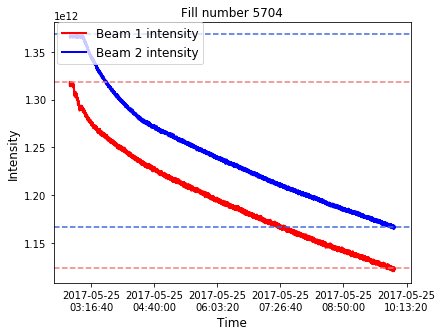

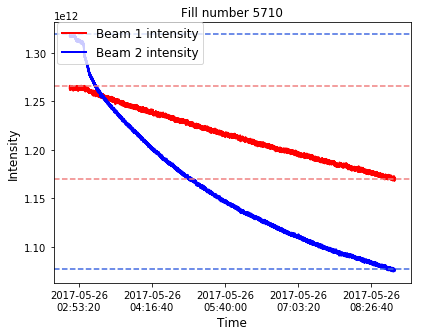

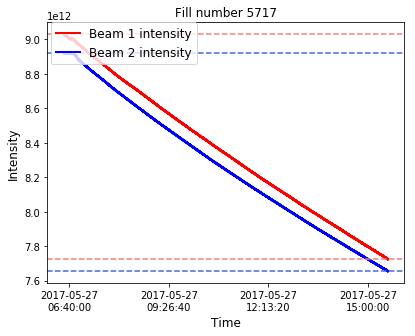

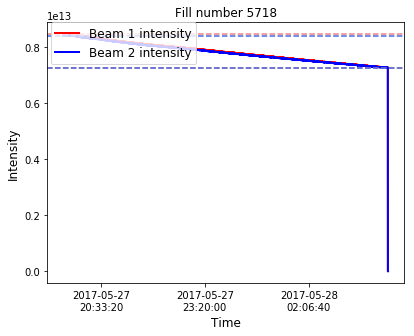

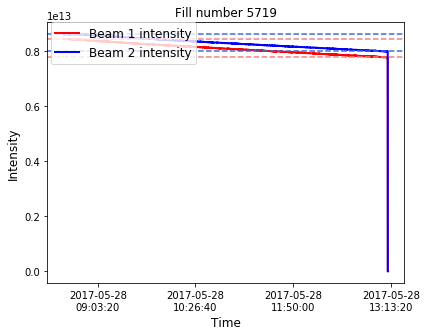

In [24]:
lost_b1 , lost_b2 = plotFills (vec_fillnumbers, dict_fillsize, dict_tstart, dict_tend,tt_int_b1,vv_int_b1,tt_int_b2,vv_int_b2) 



In [25]:
# luminosity burn-off = number of protons lost in LHC collisions for each beam
lumi_burnoff = (50.11+49.96+1.75)*1e15*76*1e-3
print ("Lumi burnoff: " , '{:0.3e}'.format(lumi_burnoff))

# dumped protons = protons extracted from the LHC at the end of each fill
print ("Dumped protons b1: " , '{:0.3e}'.format(lost_b1))
print ("Dumped protons b2: " , '{:0.3e}'.format(lost_b2))

Lumi burnoff:  7.738e+15
Dumped protons b1:  9.745e+15
Dumped protons b2:  8.652e+15


In [26]:
# Lost protons in collimators and absorbers, calculated as the difference between the total lost protons and the luminosity burn-off

print ("Non-lumi losses b1: " , '{:0.3e}'.format(lost_b1-lumi_burnoff))
print ("Non-lumi losses b2: " , '{:0.3e}'.format(lost_b2-lumi_burnoff))
print ("Non-lumi losses b1+b2: " , '{:0.3e}'.format(lost_b1+lost_b2-2*lumi_burnoff))

Non-lumi losses b1:  2.007e+15
Non-lumi losses b2:  9.139e+14
Non-lumi losses b1+b2:  2.921e+15
